In [1]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
import numpy as np
import collections
from collections import Counter
import math
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

/home/jharmse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# columns to use
cols=['description', 'points']

# import data
reviews_1 = pd.read_csv('../../data/wine-reviews/winemag-data_first150k.csv', index_col=False, usecols=cols)
reviews_2 = pd.read_csv('../../data/wine-reviews/winemag-data-130k-v2.csv', index_col=False, usecols=cols)

print("Number of entries in dataset 1: %s" %reviews_1.shape[0])
print("Number of entries in dataset 2: %s" %reviews_2.shape[0])

duplicates = set(reviews_1.description).intersection(set(reviews_2.description))

print("\nNumber of duplicate entries across datasets: %s" % len(duplicates))

# concatenate and drop duplicates
data = pd.concat([reviews_1,reviews_2]).drop_duplicates().reset_index(drop=True)
data.drop_duplicates(inplace=True)

print("\nNumber of unique reviews: %s" % data.shape[0])

data.head()

Number of entries in dataset 1: 150930
Number of entries in dataset 2: 129971

Number of duplicate entries across datasets: 48346

Number of unique reviews: 169461


,description,points
0,This tremendous 100% varietal wine hails from ...,96
1,"Ripe aromas of fig, blackberry and cassis are ...",96
2,Mac Watson honors the memory of a wine once ma...,96
3,"This spent 20 months in 30% new French oak, an...",96
4,"This is the top wine from La Bégude, named aft...",95


In [3]:
def text_cleaning(data):

    # punctuation to remove
    punc_remove = string.punctuation
    punc_remove = punc_remove.replace('%', '')

    # stopwords to remove
    stop_words = stopwords.words('english')

    # lowercase
    data['description'] = data.description.str.lower()
    # remove punctuation
    data['description'] = data.description.str.replace('[' + punc_remove + ']', '')
    # replace percentage sign
    data['description'] = data.description.str.replace('%', ' percent')
    # replace underscores
    data['description'] = data.description.str.replace('_', ' ')
    # tokenize
    data['description'] = data['description'].apply(word_tokenize)
    # remove stop words
    data['description'] = data['description'].apply(lambda x: [word for word in x if word not in stop_words])
    # word stemming
    porter = PorterStemmer()
    data['description'] = data['description'].apply(lambda x: [porter.stem(word) for word in x])
    
    return data

data = text_cleaning(data)

data.head()

,description,points
0,"[tremend, 100, percent, variet, wine, hail, oa...",96
1,"[ripe, aroma, fig, blackberri, cassi, soften, ...",96
2,"[mac, watson, honor, memori, wine, made, mothe...",96
3,"[spent, 20, month, 30, percent, new, french, o...",96
4,"[top, wine, la, bégude, name, highest, point, ...",95


In [5]:
def create_vocabulary(documents):
    """Unique words and counts"""
    vocabulary = Counter()

    for row in documents:
        vocabulary.update(row)
        
    return vocabulary

documents = list(data.description)
vocabulary = create_vocabulary(documents)
vocabulary_size = len(vocabulary)

print("Number of unique words: %s" % vocabulary_size)

Number of unique words: 45426


In [70]:
def top_vocabulary(vocabulary, n_words=35000):
    """Limit vocabulary to highest occurring words and create IDs."""
    vocabulary_n = list(dict(vocabulary.most_common(n_words - 1)).keys())
    vocabulary_n.append('UNK') # placeholder for rare words
    
    vocabulary_n = dict(zip(vocabulary_n, random.sample(range(0, n_words+1), n_words)))
            
    return vocabulary_n

vocabulary_n = top_vocabulary(vocabulary)

In [71]:
def map_vocabulary(vocabulary, map_table):
    """Map vocabulary words to IDs"""
    vocabulary_map_table = dict.fromkeys(vocabulary.keys(), 0)
    for word in vocabulary:
        if word not in map_table:
            vocabulary_map_table[word] = map_table['UNK']
        else:
            vocabulary_map_table[word] = map_table[word]
            
    return vocabulary_map_table
    
vocabulary_map_table = map_vocabulary(vocabulary, vocabulary_n)

In [72]:
def map_documents(documents, vocabulary_map_table):
    """Map documents to integer word IDs"""
    documents_mapped = [[vocabulary_map_table[word] for word in doc] for doc in documents]
    
    return documents_mapped
    
documents_mapped = map_documents(documents, vocabulary_map_table)         

In [81]:
review_index = 0 # keep track of training batches
word_index = 0  # keep track of training batches
total_num_words = sum([len(doc) for doc in documents_mapped])

In [82]:
print("Total number of words in reviews: %d" % total_num_words)

Total number of words in reviews: 4246965


In [83]:
def generate_batch(documents_mapped, batch_size, num_skips, skip_window):
    
    global review_index
    global word_index
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span considers window on both sides of target word
    # we could potentially consider a full sentence or review
    # as the context, but keeping it simpler for now
    span = 2 * skip_window + 1 
    
    # init buffer (context and target words)
    buffer = collections.deque(maxlen=span)
    
    # go back to first review if no more reviews left
    if review_index >= len(documents_mapped):
        review_index = 0
        word_index = 0
    
    # make sure there are enough words for skip-gram
    # could consider moving to next review instead of recycling words
    if word_index + span > len(documents_mapped[review_index]):
        word_index = max(len(documents_mapped[review_index]) - span - 1, 0)
    
    # new skip-gram
    buffer.extend(documents_mapped[review_index][word_index:word_index + span])
        
    for i in range(batch_size // num_skips):
        # skip_window is the same as index of target word
        context_words = [w for w in range(span) if w != skip_window]
        # randomly select context word indices to use
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            # target word
            batch[i * num_skips + j] = buffer[skip_window]
            # context word
            labels[i * num_skips + j, 0] = buffer[context_word]
        
        # add next words / new review for skips
        if word_index + span >= len(documents_mapped[review_index]):
            # next review
            if review_index < len(documents_mapped):
                review_index += 1
            # start at the beginning if non left
            else:
                review_index = 0
            
            word_index = 0
            buffer.extend(documents_mapped[review_index][word_index:word_index + span])
            word_index += span
        else:
            # add next word in review
            buffer.append(documents_mapped[review_index][word_index])
            word_index += 1
            
    return batch, labels
            
batch_size = 50
num_skips = 5
skip_window = 3
test_batch, test_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window)       

In [84]:
assert test_batch.shape[0] == batch_size

In [85]:
print("Target sample:")
print(test_batch[:10])
print("\nContext Sample:")
print(test_labels[:10])

Target sample:
[30198 30198 30198 30198 30198 25119 25119 25119 25119 25119]

Context Sample:
[[12149]
 [27126]
 [25119]
 [12253]
 [ 3822]
 [27126]
 [ 3742]
 [ 3822]
 [12149]
 [12253]]


In [86]:
embedding_size = 256

batch_size = 100
num_skips = 5
skip_window = 3

num_sampled = 64 # number of negative examples to sample

In [87]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=batch_size) # target
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # context (what we want to predict)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # hidden layer weights
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
    # hidden layers biases
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
    # NCE because softmax is too expensive
    # is it a good or a corrupt pair (context and target)?
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights, 
                biases=nce_biases, 
                labels=train_labels, 
                inputs=embed, 
                num_sampled=num_sampled, 
                num_classes=vocabulary_size))
        
    # for viz
    tf.summary.scalar('loss', loss)
    
    # SGD - minimize loss on train data (see loss above)
    # Learning Rate = 1.0 (don't care about overfitting)
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
#     valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid)

    # summary data
    merged = tf.summary.merge_all()
    
    # init variables
    init = tf.global_variables_initializer()
    
    # saver
    saver = tf.train.Saver()    

In [88]:
num_steps = 35001 # number of unique words

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter('word2vec', session.graph)
    
    init.run()
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
        
        _, summary, loss_val = session.run(
            [optimizer, merged, loss], 
            feed_dict=feed_dict, 
            run_metadata=run_metadata)
        
        average_loss += loss_val
        
        writer.add_summary(summary, step)
        
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)
            
        if step % 500 == 0:
            if step > 0:
                average_loss /= 500
                
            print('Average loss at step', step, ': ', average_loss)
        
    final_embeddings = normalized_embeddings.eval()

    saver.save(session, 'word2vec/model.ckpt')
    
writer.close()

Initialized
Average loss at step 0 :  267.3966979980469
Average loss at step 500 :  164.53335467529297
Average loss at step 1000 :  103.69406369573976
Average loss at step 1500 :  80.68734636027112
Average loss at step 2000 :  64.9749534395162
Average loss at step 2500 :  55.132399454646674
Average loss at step 3000 :  47.53196723011123
Average loss at step 3500 :  38.539168394818844
Average loss at step 4000 :  34.714770455076724
Average loss at step 4500 :  30.634633674837975
Average loss at step 5000 :  27.06379465690179
Average loss at step 5500 :  25.97866442736846
Average loss at step 6000 :  21.89672450822466
Average loss at step 6500 :  21.596460836621162
Average loss at step 7000 :  19.67601392391819
Average loss at step 7500 :  16.997238776996205
Average loss at step 8000 :  16.644355442686706
Average loss at step 8500 :  14.127944564633696
Average loss at step 9000 :  15.519819745969402
Average loss at step 9500 :  14.244644549865626
Average loss at step 10000 :  13.14509863

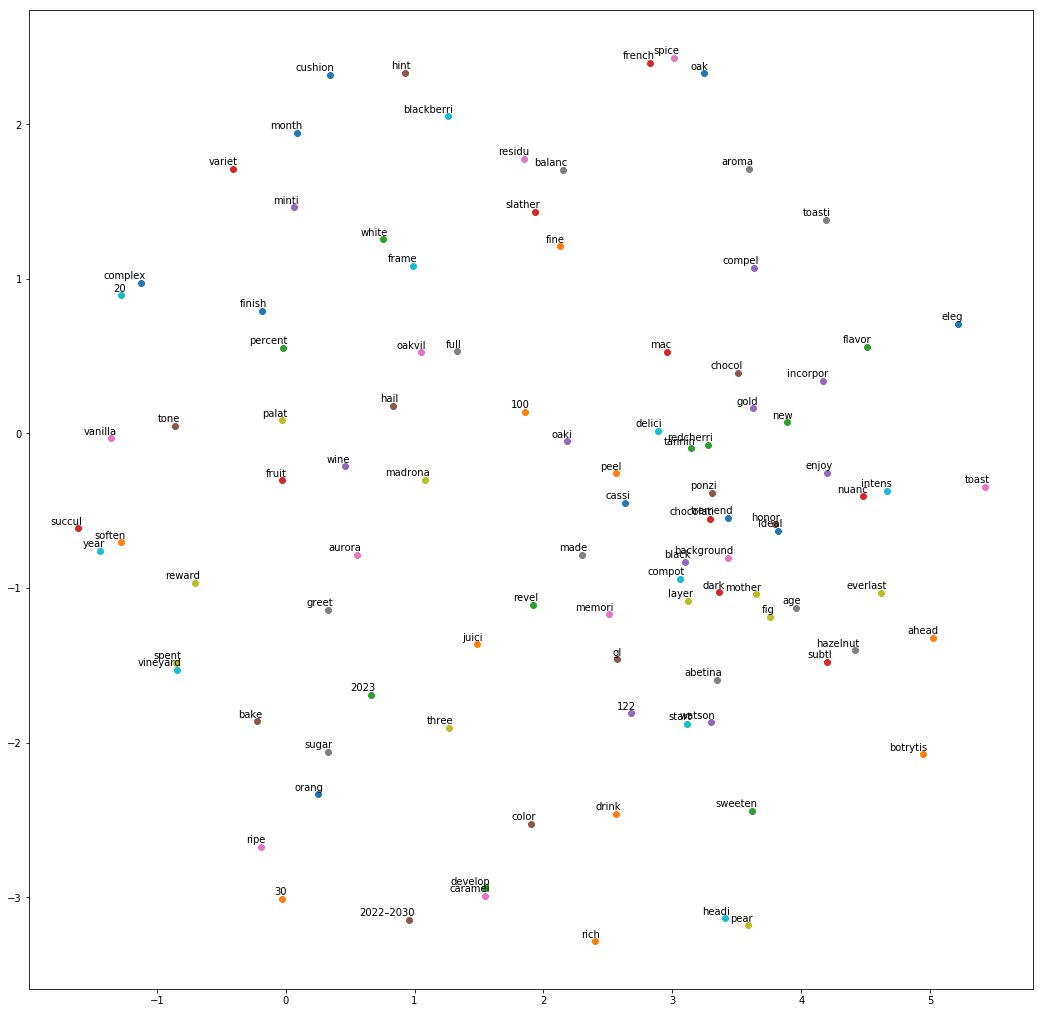

In [89]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 100
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [list(vocabulary_map_table.keys())[i] for i in range(plot_only)]

plt.figure(figsize=(18, 18))
for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

plt.show()

In [90]:
assert final_embeddings.shape[0] == len(vocabulary)

In [91]:
print("Longest review has %d words (without stop words)" % data.description.apply(len).max())
print("On average review has %d words (without stop words)" % data.description.apply(len).mean())

# restrict review length
print("95 percent quantile review number of words (without stop words): %d" % data.description.apply(len).quantile(0.95))

Longest review has 83 words (without stop words)
On average review has 25 words (without stop words)
95 percent quantile review number of words (without stop words): 38


In [92]:
max_review_length =  int(data.description.apply(len).quantile(0.95))

In [93]:
train_index = 0

def generate_train_batch(documents_mapped, output, batch_size):
    
    global train_index
    global max_review_length
    
    # pad with zeros if necessary
    batch = np.zeros(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(train_index, batch_size):
        seq_len = min(len(documents_mapped[i]), max_review_length)
        batch[i, :seq_len] = documents_mapped[i][:seq_len]
        labels[i] = output[i]
        train_index += 1
        
        if train_index >= len(documents_mapped):
            train_index = 0
            
    return batch, labels


def generate_test_batch(documents_mapped, output):
    
    global max_review_length

    batch_size = len(output)
    
    batch = np.zeros(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        seq_len = min(len(documents_mapped[i]), max_review_length)
        batch[i, :seq_len] = documents_mapped[i][:seq_len]
        labels[i] = output[i]
            
    return batch, labels

In [94]:
documents_mapped_train, documents_mapped_validate, points_train, points_validate = train_test_split(
    documents_mapped, 
    data.points.values, 
    test_size=0.2, 
    random_state=1234)

In [95]:
validation_X, validation_y = generate_test_batch(documents_mapped_validate, points_validate)

In [105]:
batch_size = 24
h_units = 12
learning_rate = 0.05

In [106]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size, max_review_length]) # review
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # review points (predict)
        validation_inputs = tf.constant(validation_X)
        validation_labels = tf.constant(validation_y)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(
            final_embeddings)
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    with tf.name_scope('LSTM_1'):
        lstmCell = tf.contrib.rnn.BasicLSTMCell(h_units)
        # drop out
        lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.9)
        # unroll
        value, _ = tf.nn.dynamic_rnn(lstmCell, embed, dtype=tf.float32)
    
    # output layer weights
    with tf.name_scope('weights'):
        output_weights = tf.Variable(tf.truncated_normal([h_units, 1],
                      stddev=1.0 / math.sqrt(embedding_size)))
    # output layers biases
    with tf.name_scope('bias'):
        output_bias = tf.Variable(tf.zeros([1]))
        
    value = tf.transpose(value, [1, 0, 2])
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    
    predictions = tf.add(tf.matmul(last, output_weights), output_bias)
    
    # validation
    validation_embed = tf.nn.embedding_lookup(embeddings, validation_inputs)
    validation_value, _ = tf.nn.dynamic_rnn(lstmCell, 
                                               validation_embed, 
                                               dtype=tf.float32)
    validation_value = tf.transpose(validation_value, [1, 0, 2])
    validation_last = tf.gather(validation_value, int(validation_value.get_shape()[0]) - 1)
    validation_predictions = tf.add(tf.matmul(validation_last, output_weights), output_bias)
    
    # MSE since linear output
    with tf.name_scope('loss'):
        loss = tf.losses.mean_squared_error(
            labels=train_labels, 
            predictions=predictions)
        
        validation_loss = tf.losses.mean_squared_error(
            labels=validation_labels, 
            predictions=validation_predictions)
        
    # for viz
    tf.summary.scalar('loss', loss)
    
    # SGD - minimize loss on train data (see loss above)
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    # summary data
    merged = tf.summary.merge_all()
    
    # init variables
    init = tf.global_variables_initializer()
    
    # saver
    saver = tf.train.Saver()

In [109]:
num_steps = 2 * len(points_train) // batch_size

tf.reset_default_graph()

with tf.Session(graph=graph) as session:
    
    writer = tf.summary.FileWriter('lstm', session.graph)
    
    init.run()
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_train_batch(documents_mapped_train, points_train, batch_size)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        run_metadata = tf.RunMetadata()
        
        _, summary, loss_val = session.run(
            [optimizer, merged, loss], 
            feed_dict=feed_dict, 
            run_metadata=run_metadata)
        
        average_loss += loss_val
        
        writer.add_summary(summary, step)
        
        if step == (num_steps - 1):
            writer.add_run_metadata(run_metadata, 'step%d' % step)
            
        if step % 200 == 0:
            if step > 0:
                average_loss = average_loss / 201
                
                print('Training loss at step', step, ': ', average_loss)
                print('Validation loss at step', step, ': ', validation_loss.eval())

                average_loss = 0

    saver.save(session, 'lstm/model.ckpt')
    
writer.close()

Initialized
Average loss at step 200 :  4358.168961140647
Validation loss at step 200 :  496.01834
Average loss at step 400 :  3720.18652829602
Validation loss at step 400 :  569.99695
Average loss at step 600 :  3719.003597733986
Validation loss at step 600 :  586.77747
Average loss at step 800 :  3718.1102471043223
Validation loss at step 800 :  691.0531


In [335]:
tf.reset_default_graph()

In [114]:
len(points_train) // batch_size

5648